## CNN Training and Classification with Chainer

We'll use the data set 'CIFAR-10' (in cPickle format).  
Download 'CIFAR-10 python version' from http://www.cs.toronto.edu/~kriz/cifar.html, extract the 'cifar-10-batches-py' directory, and then set the correct path the directory.

In [1]:
path_to_cifar10 = 'cifar-10-batches-py/'

Take the training data out using key 'data' and 'labels'.  
- data must be a numpy array with type float32  
- labels must be a numpy array with type int32  

Reshape the data into (the number of data, channels, height, width), and devide by 255 so that the each value ranges from 0 to 1.

In [2]:
import six.moves.cPickle as pickle

def unpickle(file):
    o = open(file, 'rb')
    data = pickle.load(o)
    o.close()
    return data

In [3]:
import numpy as np
train_data = []
train_labels = []

for i in range(1,6):
    batch = unpickle(path_to_cifar10 + 'data_batch_%d' % i)
    train_data.extend(batch['data'])
    train_labels.extend(batch['labels'])

train_labels = np.array(train_labels).astype(np.int32)
train_data = np.array(train_data).astype(np.float32)
train_data = train_data.reshape((len(train_data),3,32,32)) /255

Set the validation data in the same format as the traing data.

In [4]:
batch = unpickle(path_to_cifar10 + 'test_batch')
test_labels = np.array(batch['labels']).astype(np.int32)
test_data = np.array(batch['data']).astype(np.float32)
test_data = test_data.reshape(len(test_data),3,32,32) /255

The labels (0 to 9) correspond to 'label names' array in this meta batch.

In [5]:
batch = unpickle(path_to_cifar10 + 'batches.meta')
label_names = batch['label_names']
print label_names

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's take a look at some data in CIFAR-10.

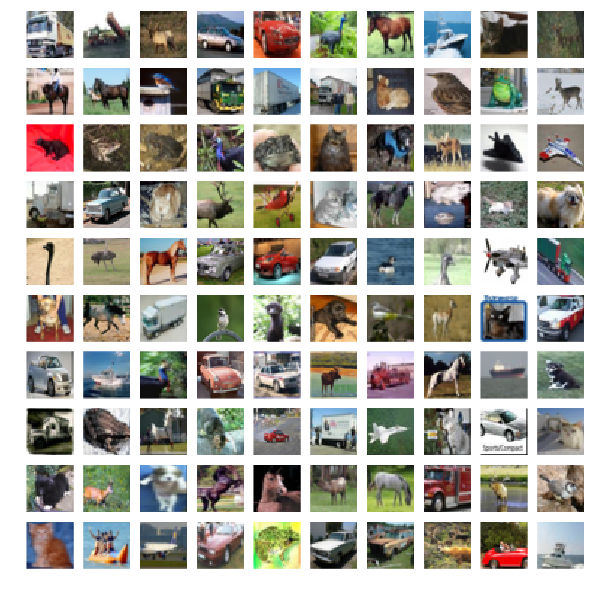

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(1,101):
    plt.subplot(10,10,i)
    plt.axis('off')
    plt.imshow(train_data[i].transpose((1,2,0)), interpolation='none')

CIFAR-10 includes 50000 images for training and 10000 for test.

In [7]:
N = len(train_labels)
N_test = len(test_labels)
print 'data for training: ' + str(N)
print 'data for test: ' + str(N_test)

data for training: 50000
data for test: 10000


Import chainer and the dependencies.

In [8]:
import six
import chainer
from chainer import computational_graph as c
from chainer import cuda
import chainer.functions as F
from chainer import optimizers
np.random.seed(0)

If you use a gpu, set the gpu device value here.

In [9]:
gpu = -1 # gpu device ID (cpu if this negative)
xp = cuda.cupy if gpu >= 0 else np

Describe the neural net architecture you want to train. The layers need training must be included in 'model', and the lest should be in 'forward' function.

In [10]:
model = chainer.FunctionSet(
    conv1=F.Convolution2D(in_channels=3, out_channels=32, ksize=3, pad=1),
    conv2=F.Convolution2D(in_channels=32, out_channels=64, ksize=3, pad=1),
    conv3=F.Convolution2D(in_channels=64, out_channels=128, ksize=3, pad=1),
    fc4=F.Linear(2048, 100),
    fc5=F.Linear(100, 10))

def forward(x_batch, train=True):
    x = chainer.Variable(x_batch)
    h1 = F.max_pooling_2d(F.relu(model.conv1(x)), ksize=2, stride=2)
    h2 = F.max_pooling_2d(F.relu(model.conv2(h1)), ksize=2, stride=2)
    h3 = F.max_pooling_2d(F.relu(model.conv3(h2)), ksize=2, stride=2)
    h4 = F.dropout(F.relu(model.fc4(h3)), train=train)
    y = F.relu(model.fc5(h4))
    return y

def loss_acc(outputs, y_batch):
    t = chainer.Variable(y_batch)
    return F.softmax_cross_entropy(outputs, t), F.accuracy(outputs, t)

Set the optimizer. (MomentumSGD, AdaDelta, AdaGrad, Adam, ...)

In [11]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
if gpu >= 0:
    cuda.get_device(gpu).use()
    model.to_gpu()
batchsize = 50

Define the 'test_net' function to get the accuracy of the validation data.

In [12]:
import sys
def prog_bar(i, length):
    prog = int(i*100.0 / length)
    n_prog = int(i*30.0 / length)
    n_lest = 30 - n_prog
    return '[' + '='*n_prog + '_'*n_lest + ']' + str(prog) + '%'

In [13]:
def test_net(x, y):
    sum_accuracy = 0
    sum_loss = 0
    for i in six.moves.range(0, len(y), batchsize):
        x_batch = xp.asarray(x[i:i + batchsize])
        y_batch = xp.asarray(y[i:i + batchsize])
        outputs = forward(x_batch, train=False)
        loss, acc = loss_acc(outputs, y_batch)
        sum_loss += float(loss.data) * len(y_batch)
        sum_accuracy += float(acc.data) * len(y_batch)
        sys.stdout.write('\r\033[K' + 'testing net: ' + prog_bar(i+batchsize, len(y)))
    sys.stdout.write('  loss=' + str(sum_loss/len(y)) + ', accuracy=' + str(sum_accuracy/len(y)))
    sys.stdout.flush()
    sys.stdout.write('\n')
    return sum_loss/len(y), sum_accuracy /len(y)

In [14]:
losses, test_its, test_losses, test_accs = ([] for i in range(4))
test_loss, test_acc = test_net(test_data, test_labels)
test_its.append(len(losses))
test_losses.append(test_loss)
test_accs.append(test_acc)

testing net: [==============================]100%  loss=2.30461716533, accuracy=0.123099999782


We're going to train the model by using the training data 'n_epoch' times.

In [15]:
# Learning loop
n_epoch = 10
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)
    perm = np.random.permutation(N)
    
    for i in six.moves.range(0, N, batchsize):
        # training
        x_batch = xp.asarray(train_data[perm[i:i + batchsize]])
        y_batch = xp.asarray(train_labels[perm[i:i + batchsize]])
        optimizer.zero_grads()
        outputs = forward(x_batch, train=True)
        loss, acc = loss_acc(outputs, y_batch)
        loss.backward()
        optimizer.update()
        losses.append(float(loss.data))
        sys.stdout.write('\r\033[K' + 'training net: ' + prog_bar(i+batchsize, N)
            + '  batch=' + str(i/batchsize+1) + ', loss=' + str(float(loss.data)))
    sys.stdout.flush()
    sys.stdout.write('\n')
    
    # evaluate
    test_loss, test_acc = test_net(test_data, test_labels)
    test_its.append(len(losses))
    test_losses.append(test_loss)
    test_accs.append(test_acc)   
            
    # save model
    model_filename = 'cnn-cifar10-epoch%d.chainermodel' % epoch
    pickle.dump(model, open(model_filename, 'wb'), -1)

('epoch', 1)
training net: [==============================]100%  batch=1000, loss=1.4885071516
testing net: [==============================]100%  loss=1.37116011143, accuracy=0.518099999279
('epoch', 2)
training net: [==============================]100%  batch=1000, loss=1.06239748001
testing net: [==============================]100%  loss=1.12205273569, accuracy=0.593100004345
('epoch', 3)
training net: [==============================]100%  batch=1000, loss=0.647383391857
testing net: [==============================]100%  loss=1.00298924565, accuracy=0.644200005978
('epoch', 4)
training net: [==============================]100%  batch=1000, loss=1.0389097929
testing net: [==============================]100%  loss=0.926540217698, accuracy=0.682300002575
('epoch', 5)
training net: [==============================]100%  batch=1000, loss=0.786042392254
testing net: [==============================]100%  loss=0.933451126218, accuracy=0.684800002873
('epoch', 6)
training net: [===============

Plot the losses and the accuracies.

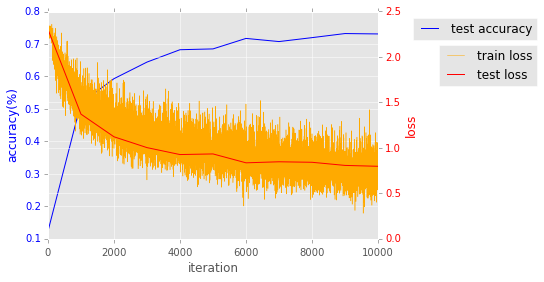

In [16]:
fig, ax1 = plt.subplots()
ax1.plot(test_its, test_accs, 'b-')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy(%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.legend(['test accuracy'], bbox_to_anchor=(1.5,1))
ax2 = ax1.twinx()
ax2.plot(range(len(losses)), losses, ls='-', lw=0.5, color='#ffaa00')
ax2.plot(test_its, test_losses, 'r-')
ax2.set_ylabel('loss', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1.5,0.88))
plt.tight_layout()
plt.show()

Now we achieved 52% accuracy after epoch 1, and 73% accuracy after epoch 10 in the validation data. Let's classify one of the data.

In [17]:
def predict(datum, top=5):
    datum = datum.reshape(1, 3, 32, 32)
    outputs = F.softmax(forward(datum, train=False))
    results = zip(outputs.data[0], label_names)
    results.sort(reverse=True)
    print 'results: '
    for rank, (score, name) in enumerate(results[:top], start=1):
        print('#%2d | %-10s | %10.3f%%' % (rank, name, score*100))

label: ship


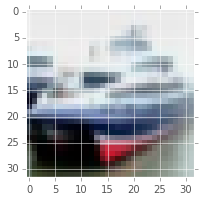

In [18]:
plt.figure(figsize=(3,3))
plt.imshow(test_data[1].transpose((1,2,0)), interpolation='none')
print 'label: ' + label_names[test_labels[1]]

In [19]:
predict(test_data[1])

results: 
# 1 | ship       |     99.958%
# 2 | airplane   |      0.034%
# 3 | automobile |      0.008%
# 4 | truck      |      0.000%
# 5 | horse      |      0.000%
